# (27m) Benchmarking on evoked

TODO:
- make sure the number of ground truth unit is the true number of units within 50 microns that spike at least once.

## Setup

activate `npx_10m_384ch_unit_classes`

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.postpro.accuracy import get_sorting_accuracies
from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object

# EVOKED
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "stimulus"
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

# SORTINGS

# kilosort 3.0
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# kilosort 2.5
KS2_5_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]

# kilosort 2.0
KS2_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort2"]["output"]

# kilosort
KS_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort"]["output"]

# hdsort (TODO: fix bug gaussmf)
#KS_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort"]["output"]

# herdingspikes
hdsp_SORTING_PATH = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]

# klusta (TODO: fix bug)

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (1,1)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-22 11:08:32,095 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-22 11:08:32,184 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (27m) Calculate unit accuracies

#### (27m) Filter sorted single units

In [37]:
# takes 27 min

# KS 3.0
matching = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)
Sorting = si.load_extractor(KS3_SORTING_PATH)
agreem_mx_ks3 = matching.agreement_scores.loc[
    :, Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"]
]

# KS 2.5
matching = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS2_5_SORTING_PATH)
Sorting = si.load_extractor(KS2_5_SORTING_PATH)
agreem_mx_ks2_5 = matching.agreement_scores.loc[
    :, Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"]
]

# KS
# note: KS does not have postprocessing that curates single units from multi-units
matching = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS_SORTING_PATH)
agreem_mx_ks = matching.agreement_scores

# Herdingspikes
# note: Herdingspikes does not have postprocessing that curates single units from multi-units
matching = get_SpikeInterface_matching_object(GT_SORTING_PATH, hdsp_SORTING_PATH)
agreem_mx_hdsp = matching.agreement_scores

#### Calculate accuracy

In [38]:
# KS 3.0
accuracies_ks3 = np.array(agreem_mx_ks3.max(axis=1).sort_values(ascending=False))
# kS 2.5
accuracies_ks2_5 = np.array(agreem_mx_ks2_5.max(axis=1).sort_values(ascending=False))
# KS 2.0 (SORTING FAILS)
# accuracies_ks2 = np.array(agreem_mx_ks2.max(axis=1).sort_values(ascending=False))
# KS
accuracies_ks = np.array(agreem_mx_ks.max(axis=1).sort_values(ascending=False))
# Herdingspikes
accuracies_hdsp = np.array(agreem_mx_hdsp.max(axis=1).sort_values(ascending=False))

### Plot

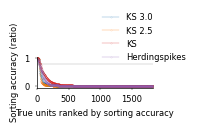

In [47]:
# set parameters
MARKERSIZE = 0.1
MARKEREDGEWIDTH = 0.1
FIGSIZE = (1.5, 0.4)
MARKER = "."

colors = (
    (0.12, 0.46, 0.70),
    (1, 0.49, 0.055),
    (0.173, 0.627, 0.173),
    (0.839, 0.153, 0.157),
    (0.58, 0.404, 0.741),
)


# count units
n_units = max(
    [
        len(accuracies_ks3),
        len(accuracies_ks2_5),
        len(accuracies_ks),
        len(accuracies_hdsp),
    ]
)

# plot accuracy (agreement score)
fig, ax = plt.subplots(1, figsize=FIGSIZE)

# plot
ax.plot(
    accuracies_ks3,
    label=f"KS 3.0",
    marker=MARKER,
    color=colors[0],
    linestyle="-",
    markersize=MARKERSIZE,
)
ax.plot(
    accuracies_ks2_5,
    label=f"KS 2.5",
    marker=MARKER,
    # markerfacecolor=colors[0],
    # markeredgecolor="w",
    color=colors[1],
    linestyle="-",
    markersize=MARKERSIZE,
    # markeredgewidth=MARKEREDGEWIDTH,
)

# ax.plot(
#     accuracies_ks2,
#     label=f"KS 2.0",
#     marker=MARKER,
#     color=colors[2],
#     linestyle="-",
#     markersize=MARKERSIZE,
#     # markeredgewidth=MARKEREDGEWIDTH,
# )

ax.plot(
    accuracies_ks,
    label=f"KS",
    marker=MARKER,
    color=colors[3],
    linestyle="-",
    markersize=MARKERSIZE,
)


ax.plot(
    accuracies_hdsp,
    label=f"Herdingspikes",
    marker=MARKER,
    color=colors[4],
    linestyle="-",
    markersize=MARKERSIZE,
)

ax.hlines(y=0.8, xmin=0, xmax=n_units, color=(0.5, 0.5, 0.5))

# add legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Sorting accuracy (ratio)")
ax.set_xlabel("True units ranked by sorting accuracy")
ax.set_xlim([-5, n_units])

ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(0.5, 0.6))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/true_unit_accuracies_evoked.svg",
    **savefig_cfg,
)

#### Plot well detected ratio

In [49]:
print(sum(accuracies_ks3 >= 0.8) / accuracies_ks3.shape[0])
print(sum(accuracies_ks2_5 >= 0.8) / accuracies_ks2_5.shape[0])
# print(sum(accuracies_ks2 >= 0.8) / accuracies_ks2.shape[0])
print(sum(accuracies_ks >= 0.8) / accuracies_ks.shape[0])
print(sum(accuracies_hdsp >= 0.8) / accuracies_hdsp.shape[0])

0.020697167755991286
0.0196078431372549
0.026688453159041396
0.017429193899782137
